# A demo of clustering algorithms for recovering open clusters in _Gaia_ data

A quick notebook to demonstrate some clustering algorithms!

You will need...

* Python 3.6+
* numpy
* pandas
* pyarrow or fastparquet to be able to read .parquet files
* matplotlib
* scikit-learn
* hdbscan

# Imports


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import hdbscan
import time

import sklearn.cluster
import sklearn.mixture
from pathlib import Path


# Helper functions

Here are three helper functions to make plotting clusters and running algorithms simpler.

### Plot helpers
(various functions taken from upcoming `ocelot` module)

In [69]:
from dataclasses import dataclass


def calculate_alpha(
    fig,
    ax,
    n_points: int,
    marker_size: float,
    desired_max_density: float = 0.1,
    scale_with_dpi: bool = False,
    max_alpha: float = 0.3,
    min_alpha: float = 0.001,
    scatter_plot: bool = False,
):
    """Calculates the optimum alpha value for points to make the plot not be
    over-saturated. Relies on the area value being correctly calculated
    prior to input, which should be the value in inches for the figure. It also
    assumes that all points are uniformly distributed across the figure area
    (which they often are not), so the input area number may need tweaking.

    Args:
        fig (matplotlib figure): the figure element. Required to calculate alpha values precisely.
        ax (matplotlib axis): the figure element. Required to calculate alpha values precisely.
        n_points (int): the number of points to plot.
        marker_size (px): the radius of the marker. Note that plt.scatter()
            specifies marker *area* but plt.plot() uses marker size, which is
            analogous to the marker radius. In the former case, ensure scatter_plot is True.
        scale_with_dpi (bool): whether or not to scale alpha values with the dpi of the figure.
            Default: False (correct for scatter plots)
        desired_max_density (float): tweakable parameter that was found to
            produce the best results. Simply mutliplying the area value is
            probably easier for normal function use, though.
            Default: 0.1.
        max_alpha (float): max alpha value to allow.
            Default: 0.3
        min_alpha (float): min alpha value to allow.
            Default: 0.001
        scatter_plot (str): whether to calculate alpha values for a scatter plot, which specifies the marker_size as an
            area, *not* a radius!

    Returns:
        float: A recommended alpha value to use on these axes.

    Todo: could still consider if the data are clumped or not

    """
    # We calculate the area of the figure with some fancy magic
    # See https://stackoverflow.com/questions/19306510/determine-matplotlib-axis-size-in-pixels
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    area = bbox.width * bbox.height

    # Scatter plots are awkward (see above function docs)
    if scatter_plot:
        marker_area = n_points * marker_size  # In units of px
    else:
        marker_area = n_points * np.pi * marker_size**2  # In units of px

    # We aim to have a maximum density of uniform_max_density, assuming that
    # n_points are distributed evenly across the area.
    if scale_with_dpi:
        total_area = area * fig.dpi**2
    else:
        total_area = area * 100**2  # If not, we just use the default area
    current_max_density = marker_area / total_area

    # We only do the alpha calculation if current max density is non-zero, just to avoid a lil error
    if current_max_density != 0:
        return np.clip(desired_max_density / current_max_density, min_alpha, max_alpha)
    else:
        return max_alpha


def plot_on_axis_clip_aware(
    fig,
    ax,
    data_region,
    x_key,
    y_key,
    labels=None,
    probabilities=None,
    clip_to_cluster=False,
    field_std_deviations=None,
    cluster_dict=None,
):
    """Plots points on an axis and clips result (if desired) to help "zoom in" on a given plot."""
    x_field, y_field = data_region[x_key], data_region[y_key]

    # Trim the field to only show a certain amount of standard deviations of sources in a field
    x_std, y_std = np.std(x_field), np.std(y_field)
    if field_std_deviations is not None:
        x_lim = np.mean(x_field) + x_std * np.asarray([-field_std_deviations, field_std_deviations])
        y_lim = np.mean(y_field) + y_std * np.asarray([-field_std_deviations, field_std_deviations])
    else:
        x_lim = y_lim = np.asarray([None, None])

    # Update so that limits don't clip out clusters, if desired
    if clip_to_cluster and field_std_deviations is not None and labels is not None:
        # Find limits of cluster stars
        is_in_a_cluster = labels != -1
        if is_in_a_cluster.sum() > 0:
            x_min_max = x_field[is_in_a_cluster].min() - x_std / 10, x_field[is_in_a_cluster].max() + x_std / 10
            y_min_max = y_field[is_in_a_cluster].min() - y_std / 10, y_field[is_in_a_cluster].max() + y_std / 10

            # Update limits to include these
            x_lim = np.clip(x_lim, np.asarray([x_min_max[0], np.inf]), np.asarray([-np.inf, x_min_max[1]]))
            y_lim = np.clip(y_lim, np.asarray([y_min_max[0], np.inf]), np.asarray([-np.inf, y_min_max[1]]))

    # Work out how many stars are valid
    if field_std_deviations is not None:
        valid_stars = np.logical_and.reduce(
            (x_field > x_lim[0], x_field < x_lim[1], y_field > y_lim[0], y_field < y_lim[1])
        )
    else:
        valid_stars = np.ones(len(x_field), dtype=bool)

    # Add field stars to the plot
    alpha_field = calculate_alpha(fig, ax, valid_stars.sum(), 1)
    ax.scatter(x_field[valid_stars], y_field[valid_stars], c="k", s=1, alpha=alpha_field, label="Unclustered")

    # Loop over clusters, adding them to the plot!
    if labels is not None:
        unique_labels = np.unique(labels)
        unique_labels = unique_labels[unique_labels != -1]

        for i, a_label in enumerate(unique_labels):
            valid_stars = labels == a_label

            # Add probability shading, if desired
            colors = plt.get_cmap("tab10")(i)
            if probabilities is not None:
                colors = np.tile(colors, (valid_stars.sum(), 1))
                colors[:, -1] = probabilities[valid_stars]

            # Add to the plot!
            ax.scatter(x_field[valid_stars], y_field[valid_stars], s=2, c=colors, label=a_label)

    # Add optional cluster locations
    if cluster_dict is not None:
        if x_key in cluster_dict and y_key in cluster_dict:
            ax.plot(cluster_dict[x_key], cluster_dict[y_key], "rx", ms=5, label=cluster_dict["name"])

    # Beautification
    ax.set(xlim=x_lim, ylim=y_lim)


### Plot a clustering result

In [72]:
DEFAULT_KEYS = {
    "x": "ra",
    "y": "dec",
    "pm_x": "pmra",
    "pm_y": "pmdec",
    "parallax": "parallax",
    "color": "bp_rp",
    "mag": "phot_g_mean_mag",
}


def plot_clustering(
    data_region,
    labels=None,
    probabilities=None,
    dpi=100,
    figsize=None,
    savename=None,
    keys=None,
    title=None,
    close_figure=False,
    legend=True,
    format="square",
    cluster_dict=None,
):
    """Plots a region of Gaia data (+ labels, which are added optionally if desired)"""
    # Decide on which keys to use!
    if keys is None:
        final_keys = DEFAULT_KEYS
    else:
        final_keys = DEFAULT_KEYS.copy()
        final_keys.update(keys)

    # Initialise matplotlib
    if format == "square":
        nrows = ncols = 2
        if figsize is None:
            figsize = (8, 8)
    elif format == "horizontal":
        nrows = 1
        ncols = 4
        if figsize is None:
            figsize = (14, 3)
    else:
        raise ValueError("specified format for layout not supported.")

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi)
    ax = ax.flatten()

    if format == "horizontal":
        fig.subplots_adjust(wspace=0.35)
    else:
        fig.subplots_adjust(wspace=0.25, hspace=0.25)

    # Add different quantities to the plots
    plot_on_axis_clip_aware(
        fig,
        ax[0],
        data_region,
        final_keys["x"],
        final_keys["y"],
        labels=labels,
        probabilities=probabilities,
        cluster_dict=cluster_dict,
    )
    plot_on_axis_clip_aware(
        fig,
        ax[1],
        data_region,
        final_keys["pm_x"],
        final_keys["pm_y"],
        labels=labels,
        probabilities=probabilities,
        field_std_deviations=2,
        clip_to_cluster=True,
        cluster_dict=cluster_dict,
    )
    plot_on_axis_clip_aware(
        fig,
        ax[2],
        data_region,
        final_keys["x"],
        final_keys["parallax"],
        labels=labels,
        probabilities=probabilities,
        field_std_deviations=2,
        clip_to_cluster=True,
        cluster_dict=cluster_dict,
    )
    plot_on_axis_clip_aware(
        fig,
        ax[3],
        data_region,
        final_keys["color"],
        final_keys["mag"],
        labels=labels,
        probabilities=probabilities,
        cluster_dict=cluster_dict,
    )

    # Beautification!
    ax[0].set(xlabel=final_keys["x"], ylabel=final_keys["y"])
    ax[1].set(xlabel=final_keys["pm_x"], ylabel=final_keys["pm_y"])
    ax[2].set(xlabel=final_keys["x"], ylabel=final_keys["parallax"])
    ax[3].set(xlabel=final_keys["color"], ylabel=final_keys["mag"], xlim=(-1, 5), ylim=(21, 6))
    # ax[3].invert_yaxis()
    fig.suptitle(title, fontsize=9)

    if legend:
        ax[0].legend(edgecolor="k", fontsize=6)

    # Output
    if savename is not None:
        fig.savefig(savename, bbox_inches="tight", facecolor="w", transparent=False)

    if close_figure:
        plt.close(fig)

    return fig, ax


### Run an algorithm on a given cluster (and time it!)

In [34]:
def run_clustering_algorithm(
    cluster_name,
    algorithm,
    labels=None,
    probabilities=None,
    dpi=100,
    figsize=None,
    savename=None,
    keys=None,
    title=None,
    close_figure=False,
    legend=True,
    format="square",
    cluster_dict=None,
    *args,
    **kwargs,
):
    # Fetch the data
    data_region = raw_field_membership_lists[cluster_name]
    data_clustering = None  # TODO

    # Run the clustering
    print(f"Running clustering algorithm {algorithm} with kwargs {kwargs}!")

    start_time = time.time()
    clusterer = algorithm(*args, **kwargs)
    labels = clusterer.fit_predict(data_clustering)
    run_time = time.time() - start_time

    print(f"  clustering took {run_time:.4f} seconds")

    # Make a string with meta info
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels != -1])

    title_string = f"{algorithm} | {kwargs}\nclusters={n_clusters} | run_time={run_time:.3f}s"

    if title is not None:
        title_string = title + "\n" + title_string

    # Plot it!
    fig, ax = plot_clustering(
        data_region,
        labels=labels,
        probabilities=None,
        dpi=dpi,
        figsize=figsize,
        savename=savename,
        final_keys=keys,
        title=title_string,
        close_figure=close_figure,
        legend=legend,
        format=format
    )

    return labels, fig, ax

# Data
You'll need about 1 GB of RAM to read this in!

## Loading the clusters

Firstly, let's load our objects...

In [66]:
data_directory = Path("../data")

data_clusters = pd.read_csv(data_directory / "cluster_ground_truth.csv")
data_clusters_named = data_clusters.set_index("name")
data_clusters

,name,ra,dec,l,b,ang_radius_t,pmra,pmra_std,pmra_error,pmdec,pmdec_std,pmdec_error,parallax,parallax_std,parallax_error,n_stars
0,Blanco_1,0.914984,-30.010616,14.757580,-79.127321,1.841029,18.724514,0.363397,0.017690,2.592620,0.323644,0.015755,4.231836,0.092326,0.004494,841
1,Gulliver_54,81.271975,33.677772,173.641632,-1.125223,0.198167,-0.507062,0.169529,0.028255,-7.265475,0.172036,0.028673,0.820390,0.056614,0.009436,70
2,Kharchenko_1,92.198047,24.286466,186.620112,2.147090,0.239004,0.741821,0.091599,0.012240,-2.324067,0.092357,0.012342,0.373766,0.038550,0.005151,56
3,King_9,333.879040,54.408018,101.444208,-1.825774,0.167967,-2.288380,0.106597,0.009041,-1.020233,0.075821,0.006431,0.145470,0.061297,0.005199,139


There are four clusters of various difficulties to recover. Parameters for them are taken from an upcoming work based on DR3. Other than Blanco 1 (which is easy to redetect), all of the clusters have at least _something_ interesting about them...

Let's pre-load the clusters so we can look at the membership lists whenever we'd like.

In [29]:
raw_field_membership_lists = dict()

for i_row, a_row in data_clusters.iterrows():
    print(f"Reading in {a_row['name']}!")
    raw_field_membership_lists[a_row["name"]] = pd.read_parquet(data_directory / f"{a_row['name']}.parquet")

    raw_field_membership_lists[a_row["name"]]["bp_rp"] = (
        raw_field_membership_lists[a_row["name"]]["phot_bp_mean_mag"]
        - raw_field_membership_lists[a_row["name"]]["phot_rp_mean_mag"]
    )
    raw_field_membership_lists[a_row["name"]]["g_rp"] = (
        raw_field_membership_lists[a_row["name"]]["phot_g_mean_mag"]
        - raw_field_membership_lists[a_row["name"]]["phot_rp_mean_mag"]
    )

print("Done")


Reading in Blanco_1!
Reading in Gulliver_54!
Reading in Kharchenko_1!
Reading in King_9!
Done


## What do they look like?

Let's take a look at all fields!

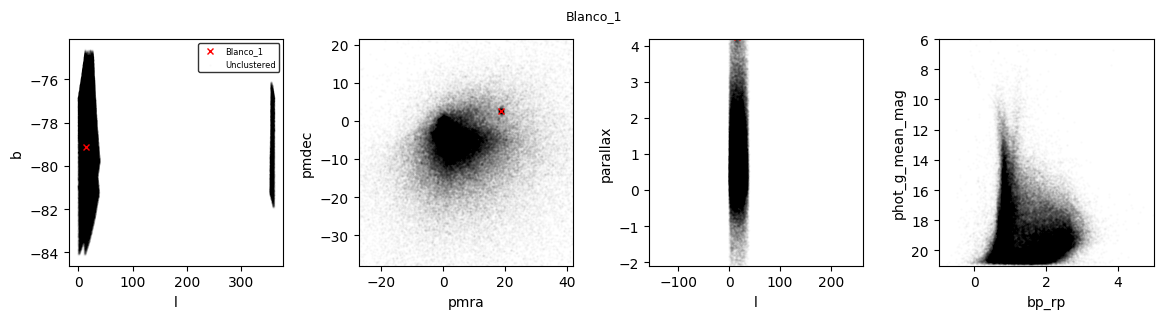

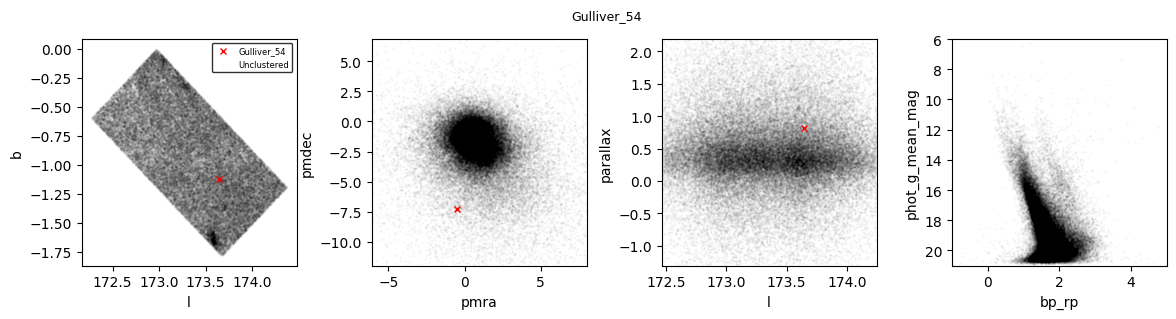

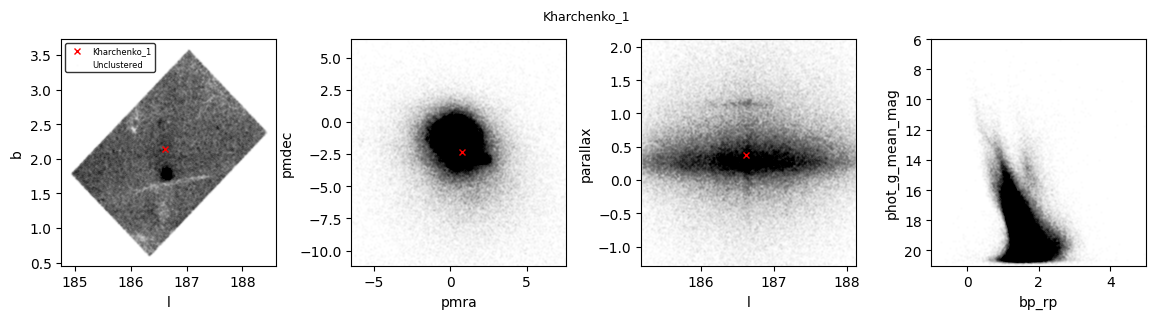

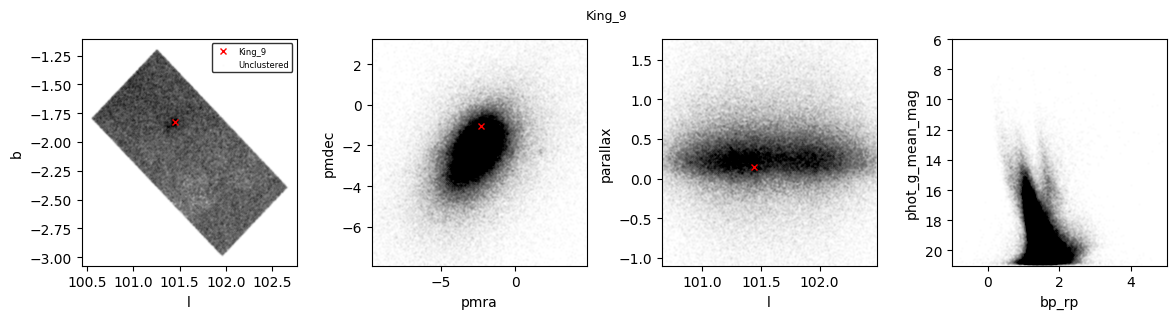

In [74]:
for i, a_cluster in enumerate(raw_field_membership_lists):
    plot_clustering(
        raw_field_membership_lists[a_cluster],
        title=a_cluster,
        format="horizontal",
        cluster_dict=data_clusters.loc[i],
        keys=dict(x="l", y="b"),
    )


There are a few things to note about these clusters!

* Blanco 1 is nearby and well-defined in proper motion, but also sits near the l=0 discontinuity. We'll need to preprocess its coordinate data to be usable.
* Gulliver 54 is not clearly visible by eye.
* Kharchenko 1 is not clearly visible by eye, but _also_ is next to a globular cluster (the black spot in l/b) _and_ is _behind_ another cluster (the horizontal line in l/parallax).
* King 9 is a visible overdensity in l/b, but has a proper motion similar to the field's bulk motion and a very small parallax.

Other than Blanco 1 (which has its own preprocessing challenges anyway!), _all_ of these clusters are in some way _difficult_.

## The clustering algorithms
Let's try various algorithms! Feel free to play around with the parameters.

### K-Means
The archetypal (and most simple) clustering algorithm...

Running clustering algorithm!
  clustering took 0.1007 seconds
Plotting results!


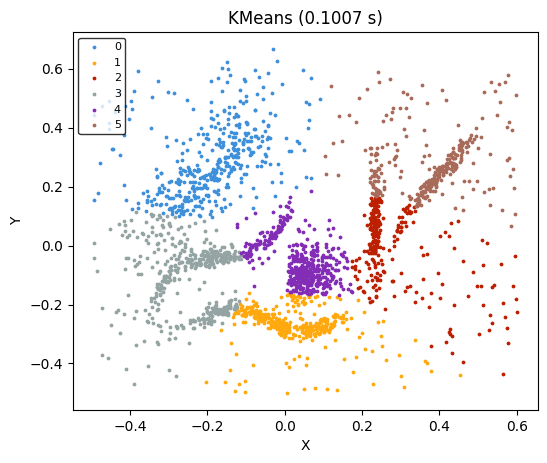

In [118]:
run_clustering_algorithm(data, sklearn.cluster.KMeans, n_clusters=6, savename='KMeans')

Basic algorithm; some things are roughly separated, but not so well.

### Gaussian mixture models
Can be considered a generalisation of the KMeans algorithm that allows clusters to have arbitrary shapes (i.e. standard deviations.)

Running clustering algorithm!
  clustering took 0.8371 seconds
Plotting results!


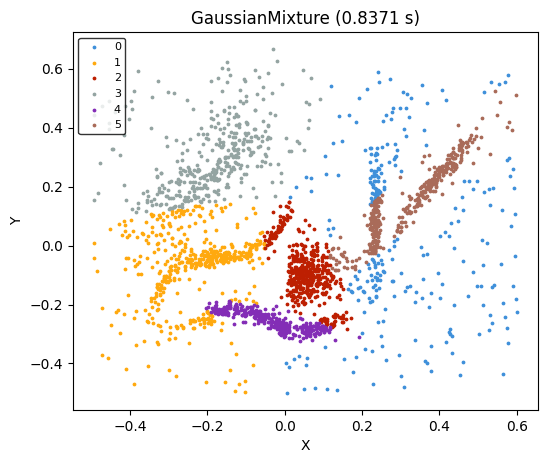

In [119]:
# I use n_init=10 (i.e. 10 trials and pick the best) for more consistent results.
# But, if this is really slow, you may want to lower that parameter!
run_clustering_algorithm(
    data, sklearn.mixture.GaussianMixture, n_components=6, n_init=10, savename='GaussianMixtureModels')

This does a better job, especially with some of the sparse objects! However, some clusters aren't so well separated.

### Agglomerative clustering
A common hierarchical algorithm

Running clustering algorithm!
  clustering took 0.0566 seconds
Plotting results!


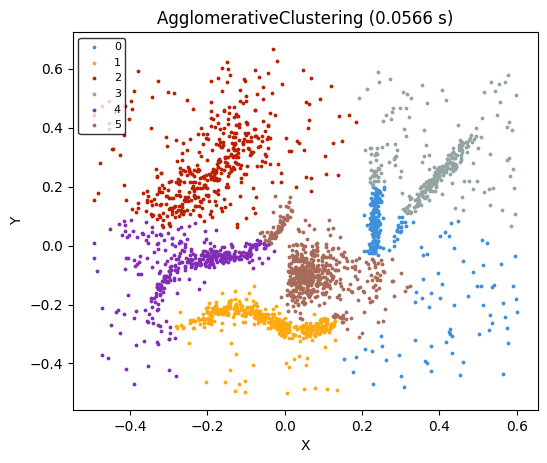

In [120]:
run_clustering_algorithm(
    data, sklearn.cluster.AgglomerativeClustering, n_clusters=6, linkage='ward', savename='AgglomerativeClustering')

That's a better result! The lower and upper (sparse) clusters are quite well separated. However, some clsuters are still merged together somewhat.

### DBSCAN

The first density-based algorithm here! Also one of the most common.

Running clustering algorithm!
  clustering took 0.0060 seconds
Plotting results!


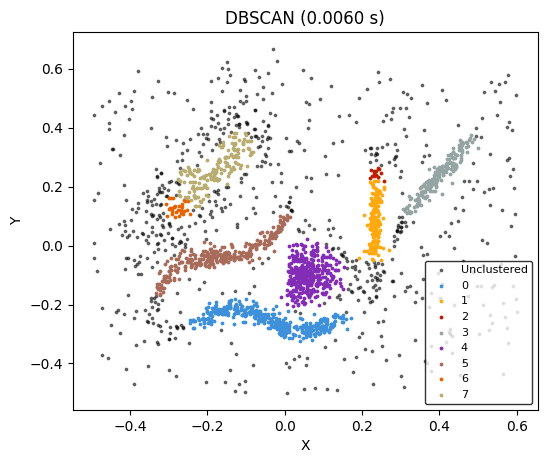

In [121]:
# The "eps" parameter requires a lot of playing around to set
run_clustering_algorithm(
    data, sklearn.cluster.DBSCAN, eps=0.03, min_samples=20, savename='DBSCAN')

Not bad! Although a couple of clusters have been erroneously split, and the sparse one in the top-left seems to be missing a few members.

### OPTICS

An extension of DBSCAN that can set epsilon autonomously!

Running clustering algorithm!
  clustering took 0.8258 seconds
Plotting results!


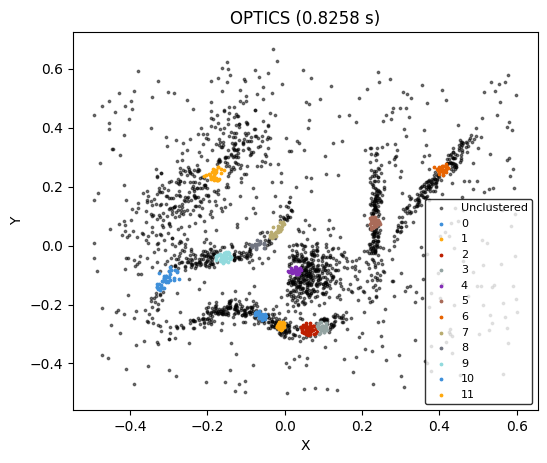

In [122]:
run_clustering_algorithm(
    data, sklearn.cluster.OPTICS, min_samples=20, savename='OPTICS')

I really struggled to get this to work nicely. Tweet me @emilydoesastro if you can do better

### HDBSCAN

An further extension of DBSCAN that combines concepts from both density-based clustering _and_ hierarchical clustering.

Running clustering algorithm!
  clustering took 0.0984 seconds
Plotting results!


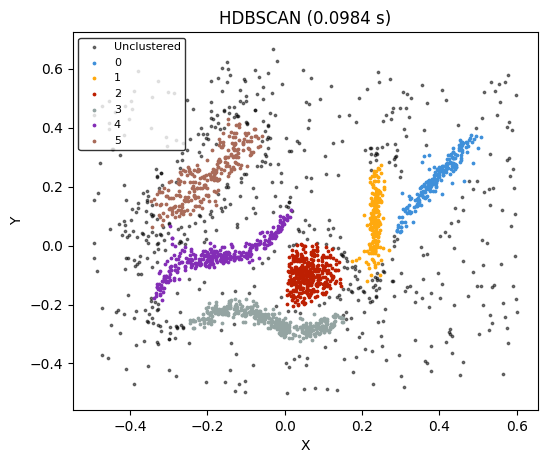

In [123]:
run_clustering_algorithm(
    data, hdbscan.HDBSCAN, min_cluster_size=20, savename='HDBSCAN')

It works really nicely on this data. HDBSCAN is my favourite! (But check out my talk for a discussion of the caveats the algorithm still has...)

## Plots

I made a few plots for the presentation, this is the code that made them by running DBSCAN a few times.

In [114]:
for an_eps in np.linspace(0.01, 0.1, num=10):
    run_clustering_algorithm(
        data, sklearn.cluster.DBSCAN, eps=an_eps, min_samples=20, savename=f"dbscan_{an_eps:.2f}.png", close_fig=True)

Running clustering algorithm!
  clustering took 0.0048 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0050 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0057 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0063 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0072 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0078 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0079 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0088 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0094 seconds
Plotting results!
Running clustering algorithm!
  clustering took 0.0101 seconds
Plotting results!
